# Natural Gradients

In this notebook, we show how to create natural gradients. Ordinary gradient descent algorithms are an undesirable for variational inference because we are minimising the KL divergence  between distributions rather than a set of parameters directly. Natural gradients, on the other hand, accounts for the curvature induced by the KL divergence that has the capacity to considerably improve performance (see e.g., <strong data-cite="salimbeni2018">Salimbeni et al. (2018)</strong> for further details).

In [1]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax as ox
from jax.config import config
from jaxutils import Dataset
import jaxkern as jk

import gpjax as gpx

# Enable Float64 for more stable matrix inversions.
config.update("jax_enable_x64", True)
key = jr.PRNGKey(123)

# Dataset:

We simulate a dataset $\mathcal{D} = (\boldsymbol{x}, \boldsymbol{y}) = \{(x_i, y_i)\}_{i=1}^{5000}$ with inputs $\boldsymbol{x}$ sampled uniformly on $(-5, 5)$ and corresponding binary outputs

$$\boldsymbol{y} \sim \mathcal{N} \left(\sin(4 * \boldsymbol{x}) + \sin(2 * \boldsymbol{x}), \textbf{I} * (0.2)^{2} \right).$$

We store our data $\mathcal{D}$ as a GPJax `Dataset` and create test inputs for later.

In [2]:
n = 5000
noise = 0.2

x = jr.uniform(key=key, minval=-5.0, maxval=5.0, shape=(n,)).sort().reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(key, shape=signal.shape) * noise

D = Dataset(X=x, y=y)
xtest = jnp.linspace(-5.5, 5.5, 500).reshape(-1, 1)

Intialise inducing points:

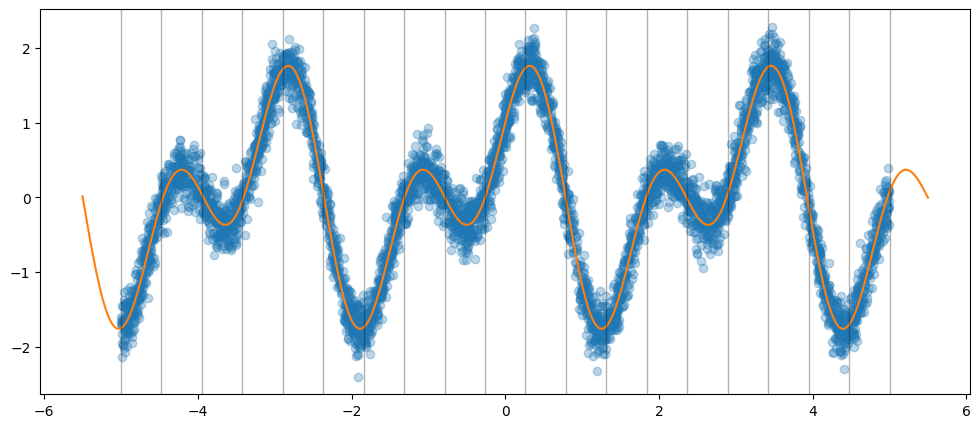

In [3]:
z = jnp.linspace(-5.0, 5.0, 20).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(x, y, "o", alpha=0.3)
ax.plot(xtest, f(xtest))
[ax.axvline(x=z_i, color="black", alpha=0.3, linewidth=1) for z_i in z]
plt.show()

# Natural gradients:

We begin by defining our model, variational family and variational inference strategy:

In [4]:
likelihood = gpx.Gaussian(num_datapoints=n)
kernel = jk.RBF()
prior = gpx.Prior(kernel=kernel)
p = prior * likelihood


natural_q = gpx.NaturalVariationalGaussian(prior=prior, inducing_inputs=z)
natural_svgp = gpx.StochasticVI(posterior=p, variational_family=natural_q)

parameter_state = gpx.initialise(natural_svgp)

/var/folders/qb/c3b8rx055411rkfvdyzty9_80000gn/T/ipykernel_4230/292367178.py:10: UserWarning: No PRNGKey specified. Defaulting to seed 123.
  parameter_state = gpx.initialise(natural_svgp)


Next, we can conduct natural gradients as follows:

In [5]:
inference_state = gpx.fit_natgrads(
    natural_svgp,
    parameter_state=parameter_state,
    train_data=D,
    num_iters=5000,
    batch_size=256,
    key=jr.PRNGKey(42),
    moment_optim=ox.sgd(0.01),
    hyper_optim=ox.adam(1e-3),
)

learned_params, training_history = inference_state.unpack()

  0%|          | 0/5000 [00:00<?, ?it/s]

Here is the fitted model:

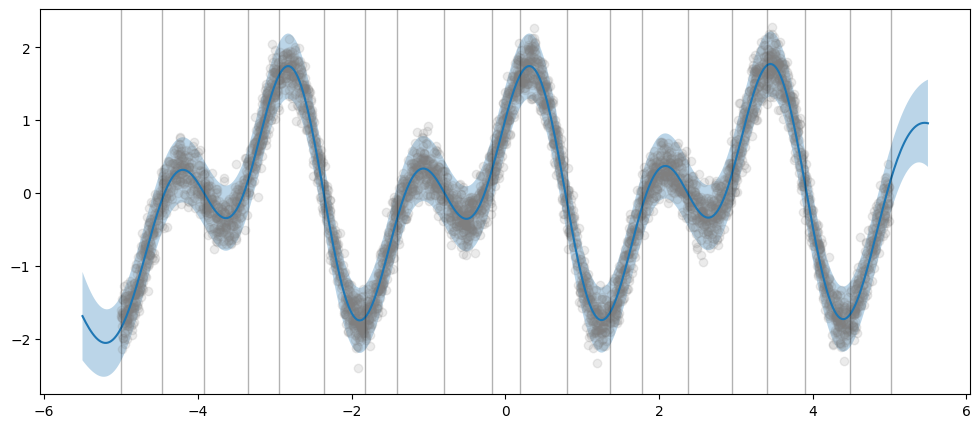

In [6]:
latent_dist = natural_q(learned_params)(xtest)
predictive_dist = likelihood(learned_params, latent_dist)

meanf = predictive_dist.mean()
sigma = predictive_dist.stddev()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(x, y, "o", alpha=0.15, label="Training Data", color="tab:gray")
ax.plot(xtest, meanf, label="Posterior mean", color="tab:blue")
ax.fill_between(xtest.flatten(), meanf - sigma, meanf + sigma, alpha=0.3)
[
    ax.axvline(x=z_i, color="black", alpha=0.3, linewidth=1)
    for z_i in learned_params["variational_family"]["inducing_inputs"]
]
plt.show()

# Natural gradients and sparse varational Gaussian process regression:

As mentioned in <strong data-cite="hensman2013gaussian">Hensman et al. (2013)</strong>, in the case of a Gaussian likelihood, taking a step of unit length for natural gradients on a full batch of data recovers the same solution as <strong data-cite="titsias2009">Titsias (2009)</strong>. We now illustrate this.

In [7]:
n = 1000
noise = 0.2

x = jr.uniform(key=key, minval=-5.0, maxval=5.0, shape=(n,)).sort().reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(key, shape=signal.shape) * noise

D = Dataset(X=x, y=y)

xtest = jnp.linspace(-5.5, 5.5, 500).reshape(-1, 1)

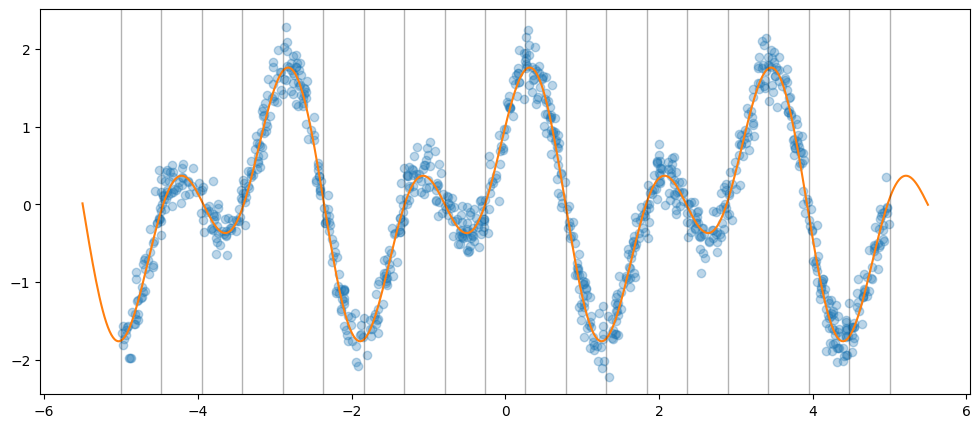

In [8]:
z = jnp.linspace(-5.0, 5.0, 20).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(x, y, "o", alpha=0.3)
ax.plot(xtest, f(xtest))
[ax.axvline(x=z_i, color="black", alpha=0.3, linewidth=1) for z_i in z]
plt.show()

In [9]:
likelihood = gpx.Gaussian(num_datapoints=n)
kernel = jk.RBF()
prior = gpx.Prior(kernel=kernel)
p = prior * likelihood

We begin with natgrads:

In [10]:
from gpjax.natural_gradients import natural_gradients

q = gpx.NaturalVariationalGaussian(prior=prior, inducing_inputs=z)
svgp = gpx.StochasticVI(posterior=p, variational_family=q)
params, trainables, bijectors = gpx.initialise(svgp).unpack()

params = gpx.unconstrain(params, bijectors)

nat_grads_fn, hyper_grads_fn = natural_gradients(svgp, D, bijectors, trainables)

moment_optim = ox.sgd(1.0)

moment_state = moment_optim.init(params)

# Natural gradients update:
loss_val, loss_gradient = nat_grads_fn(params, D)
print(loss_val)

updates, moment_state = moment_optim.update(loss_gradient, moment_state, params)
params = ox.apply_updates(params, updates)

loss_val, _ = nat_grads_fn(params, D)

print(loss_val)

/var/folders/qb/c3b8rx055411rkfvdyzty9_80000gn/T/ipykernel_4230/1500448229.py:5: UserWarning: No PRNGKey specified. Defaulting to seed 123.
  params, trainables, bijectors = gpx.initialise(svgp).unpack()


295437.8825930597


1181.8416399556033


Let us now run it for SGPR:

In [11]:
q = gpx.CollapsedVariationalGaussian(
    prior=prior, likelihood=likelihood, inducing_inputs=z
)
sgpr = gpx.CollapsedVI(posterior=p, variational_family=q)

params, _, _ = gpx.initialise(svgp).unpack()

loss_fn = sgpr.elbo(D, negative=True)

loss_val = loss_fn(params)

print(loss_val)

/var/folders/qb/c3b8rx055411rkfvdyzty9_80000gn/T/ipykernel_4230/4229406286.py:6: UserWarning: No PRNGKey specified. Defaulting to seed 123.
  params, _, _ = gpx.initialise(svgp).unpack()


1181.7996176401755


The discrepancy is due to the quadrature approximation.

## System configuration

In [12]:
%reload_ext watermark
%watermark -n -u -v -iv -w -a 'Daniel Dodd'

Author: Daniel Dodd

Last updated: Sat Jan 14 2023

Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.8.0

jaxkern   : 0.0.4
matplotlib: 3.3.3
gpjax     : 0.5.8
optax     : 0.1.4
jax       : 0.4.1

Watermark: 2.3.1

